
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [10]:
!pip install category_encoders==2.*

     |████████████████████████████████| 81kB 4.4MB/s 


In [16]:
!pip install shap

     |████████████████████████████████| 327kB 5.0MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456464 sha256=91f7cf02286846369372892369c270be15ab8c8e584d3f1b2293a7ba69d27e86
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [1]:
# We'll upload our file to our google colab
from google.colab import files
uploaded = files.upload()


Saving final_dataset_form.csv to final_dataset_form.csv


In [2]:
# Import pandas and io, make our dataset
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['final_dataset_form.csv']))
# Dataset is now stored in a Pandas Dataframe

In [3]:
# We'll drop both the duplicated index column and the year of founding column, since it's already represented by the Est. founding date
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('year of founding', axis=1, inplace=True)

In [4]:
# Separate our X and Y
X = df.drop('Dependent-Company Status', axis=1)
y = df['Dependent-Company Status']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
# import libraries for pipeline 
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
# Make the pipeline
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
)

In [13]:
# Fit our data
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Focus functions of company',
                                      'Has the team size grown',
                                      'Est. Founding Date',
                                      'Country of company',
                                      'Presence of a top angel or venture fund '
                                      'in previous round of investment',
                                      'Number of  Sales Support material',
                                      'Worked in top companies',
                                      'Average size of companies worked for in '
                                      'the past',
                                      'Have been part of startups in the past?'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytr

In [23]:
import matplotlib.pyplot as plt

<BarContainer object of 10 artists>

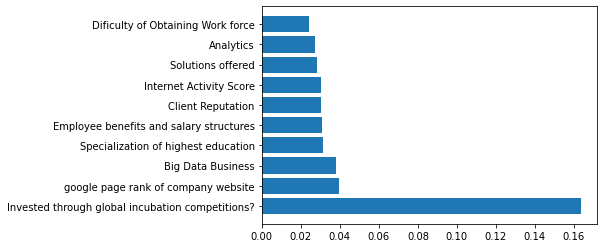

In [31]:
 
num_features = 10 
sorted_idx = model[2].feature_importances_.argsort()[-10:][::-1]
plt.barh(X.columns[sorted_idx], model[2].feature_importances_[sorted_idx])

In [32]:
from sklearn.inspection import plot_partial_dependence

In [35]:
# Make the pipeline
preprocessing = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
)

In [36]:
preprocessing.fit(X)
X_x = preprocessing.transform(X)

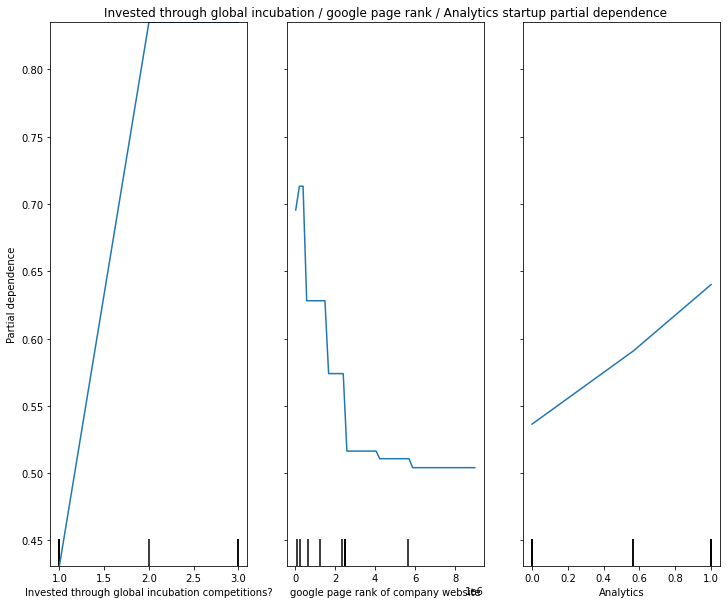

In [55]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
plot_partial_dependence(model[2], feature_names = X.columns, features=['Invested through global incubation competitions?', 'google page rank of company website', 'Analytics'], X=X_x, grid_resolution=50, ax=ax) 
ax.set_title('Invested through global incubation / google page rank / Analytics startup partial dependence')
ax.animated = True
plt.show()

In [40]:
df['Invested through global incubation competitions?'].value_counts()

No     285
Yes     51
Name: Invested through global incubation competitions?, dtype: int64

In [43]:
df['google page rank of company website'].nunique()

310

In [44]:
import shap

In [45]:
X_train_x = preprocessing.transform(X_train)

In [46]:
explainer = shap.TreeExplainer(model[2])
shap_values = explainer.shap_values(X_train_x)

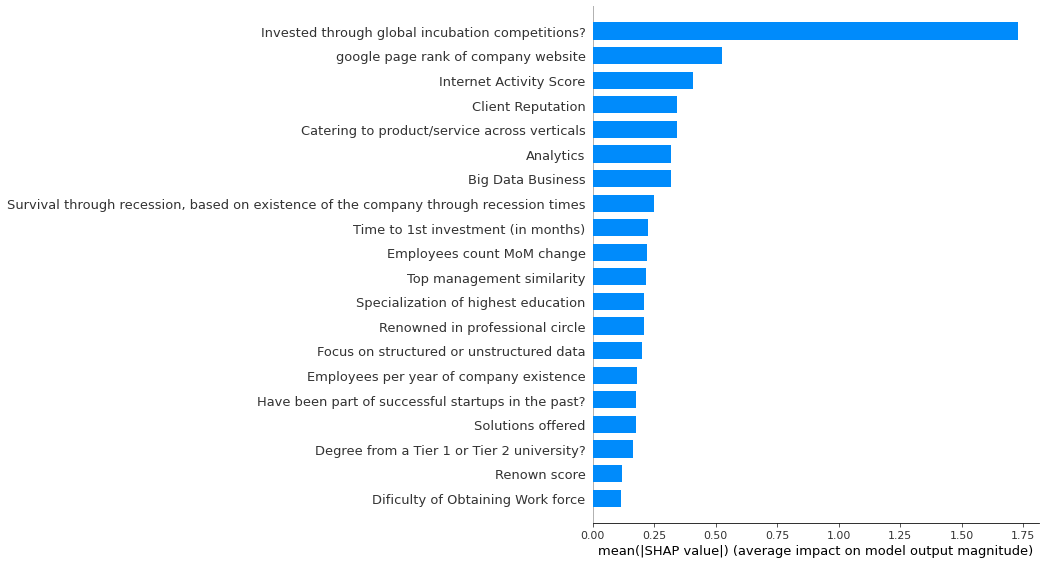

In [58]:
shap.summary_plot(shap_values, X.columns, plot_type="bar")
plt.show()